# What is t-SNE?

**t-SNE** (t-distributed Stochastic Neighbor Embedding) is a powerful technique for non-linear dimensionality reduction. It allows us to explore high-dimensional data by visualizing it in a lower-dimensional space. Unlike linear techniques such as PCA (Principal Component Analysis), t-SNE can separate data that cannot be separated by a straight line. Here are the key points:

1. Non-linear Dimensionality Reduction: t-SNE focuses on preserving pairwise similarities between data points in a lower-dimensional space. It allows us to understand underlying patterns and relationships in complex data.
2. Comparison with PCA: While PCA preserves variance in the data, t-SNE preserves relationships between data points. PCA works best with linearly structured data, whereas t-SNE is ideal for visualizing complex high-dimensional data.

## How t-SNE Works:

1. Pairwise Similarity Calculation:

- t-SNE starts by calculating pairwise similarities between all data points in the high-dimensional space using a Gaussian kernel.
- Points that are far apart have a lower probability of being picked than points close together.

2. Mapping to Lower Dimensional Space:

- The algorithm then maps higher-dimensional data points onto a lower-dimensional space while preserving pairwise similarities.
- It aims to minimize the divergence between the probability distributions of pairwise similarities in the high-dimensional and low-dimensional spaces.

3. Preserving Local Structure:

- t-SNE focuses on preserving local structure, ensuring that similar objects are mapped closer together in the lower-dimensional space.
- It provides an intuitive view of how data is arranged in higher dimensions.

## Using t-SNE:

To use t-SNE for your data, follow these steps:

1. Data Preparation:

- Ensure you have your data organized with features (chunkContent) and their corresponding embeddings (chunkContentVector).

2. Implement t-SNE:

- Use libraries like scikit-learn to perform t-SNE.
- Specify the number of dimensions for the lower-dimensional space (usually 2 or 3 for visualization).

3. Visualize Results:

- Plot the transformed data points in the lower-dimensional space.
- Observe clusters, patterns, and relationships.


# Get to know the Data


In [54]:
%%capture --no-display
%pip install spacy
%pip install scikit-learn
%pip install seaborn
%pip install flashtext
!python -m spacy download en_core_web_sm -q
%pip install wordcloud

In [58]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from spacy.lang.en.stop_words import STOP_WORDS

import en_core_web_sm
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

plt.style.use("ggplot")
pd.set_option("display.max_colwidth", None)

## Load the data


In [69]:
import json
import os
# ROOT_DIR = os.path.dirname(os.path.abspath(__file__)) # This is your Project Root

# cwd = os.getcwd()
# print(cwd)
totalNumberOfDocuments = 200
chunk_size = 300
chunk_overlap = 0
file_path = f"../output/chunks-solution-ops-embedded-{totalNumberOfDocuments}-{chunk_size}-{chunk_overlap}.json"

if(not os.path.exists(file_path)):
    file_path = f"./output/chunks-solution-ops-embedded-{totalNumberOfDocuments}-{chunk_size}-{chunk_overlap}.json"
with open(file_path) as f:
    data = json.load(f)
    dfcluster = pd.DataFrame(rec for rec in data)

In [ ]:
# print(dfcluster.loc[100]["chunkContent"])

## Extract Azure Services as keywords


In [70]:
import string
import pandas as pd
from tqdm import tqdm
from flashtext import KeywordProcessor

file_path = "../data/Azure Service level 1 2 3 4 5.csv"
if(not os.path.exists(file_path)):
    file_path = f"./data/Azure Service level 1 2 3 4 5.csv"

df = pd.read_csv(file_path)

lst_ner4 = list(set(df["Service Level 4"].values.tolist()))
lst_l4 = ["SL4" for i in range(len(lst_ner4))]

keyword_processor = KeywordProcessor()

for word in lst_ner4:
    keyword_processor.add_keyword(word)

In [71]:
def extract_azure_services(text):
    keywords_list = keyword_processor.extract_keywords(text, span_info=False)
    keywords = " ".join(map(str, keywords_list))
    return keywords


# Extract chunkContentVectors (assuming they are already computed)
chunk_content_vectors = np.array([entry["chunkContentVector"] for entry in data])

dfcluster["chunkContent"] = (
    dfcluster["chunkContent"]
    + " and the extracted product name is "
    + dfcluster["chunkContent"].apply(extract_azure_services)
)

In [72]:
chunk_content_vectors[0]

array([-0.00085263,  0.01362777, -0.03358937, ...,  0.00374011,
        0.01511808, -0.01117735])

In [73]:
# print(dfcluster.loc[150]["chunkContent"])

## Remove stop words and lemmatise


In [74]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['against',
 'although',
 'rather',
 'seems',
 're',
 'himself',
 'thereafter',
 'four',
 'again',
 'an']

In [75]:
specific_words_to_remove = [
    "use",
    "azure",
    "emailquote",
    "margin",
    "left",
    "padding",
    "border",
    "2px",
    "1pt",
    "solid, " "microsoft",
    "customer",
    "support",
    "provide",
    "feature",
    "affected tenants",
    "business impact",
    "additional information",
    "submitted",
    "similar bugs",
    "troubleshooting",
    "casenumber",
    "tenantid",
    "severity",
    "sev3",
    "sev4",
    "#800000",
    "issue /problem",
    "detailed change request",
    "�",
    "The customer name is",
    "and their feedback is defined as:",
    ", the feature they requested is described as",
    "and the extracted product name is",
    "and its about",
    "feedback",
    "defined",
    "solution",
    "requested",
    "described",
    "extracted",
    "product",
]

In [76]:
parser = en_core_web_sm.load(disable=["ner"])
parser.max_length = 7000000


def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    # mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [word.lower_ for word in mytokens]
    mytokens = [
        word
        for word in mytokens
        if word not in stopwords
        and word not in punctuations
        and word not in specific_words_to_remove
    ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [78]:
%%capture --no-display
tqdm.pandas()
dfcluster["chunkContent"] = dfcluster["chunkContent"].progress_apply(spacy_tokenizer)

In [79]:
for word in specific_words_to_remove:
    dfcluster["chunkContent"] = dfcluster["chunkContent"].str.replace(
        word, " ", case=False
    )

In [80]:
pca = PCA(n_components=0.95, random_state=42)

# X_reduced = pca.fit_transform(X.toarray())
X = chunk_content_vectors
X_reduced = pca.fit_transform(chunk_content_vectors)
X_reduced.shape

(975, 375)

# Determine the optimal cluster number


In [81]:
print("Determine the optimal number of clusters")

Determine the optimal number of clusters


In [82]:
%%capture --no-display

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}


K = range(2, 30)  # Tweak this as needed
for k in tqdm(K):
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(
        sum(np.min(cdist(X_reduced, k_means.cluster_centers_, "euclidean"), axis=1))
        / X.shape[0]
    )
    inertias.append(k_means.inertia_)
    mapping1[k] = (
        sum(np.min(cdist(X_reduced, k_means.cluster_centers_, "euclidean"), axis=1))
        / X.shape[0]
    )
    mapping2[k] = k_means.inertia_

In [83]:
# X_line = [K[0], K[-1]]
# Y_line = [distortions[0], distortions[-1]]

# plt.plot(K, distortions, "b-")
# plt.plot(X_line, Y_line, "r")
# plt.xlabel("k")
# plt.ylabel("Distortion")
# plt.title("The Elbow Method showing the optimal k")
# plt.show()

## Find the optimum k


In [84]:
lbig = max(abs(x - y) for (x, y) in zip(distortions[1:], distortions[:-1]))

optimum_k = []

for i, distortion in enumerate(distortions):

    if i != len(distortions) - 1:
        if distortion - distortions[i + 1] == lbig:
            optimum_k.append(
                list(mapping1.keys())[list(mapping1.values()).index(distortions[i + 3])]
            )

print(f"The optimum cluster number is {optimum_k[0]} \n")

The optimum cluster number is 5 



In [85]:
# k = optimum_k[0]
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
dfcluster["y"] = y_pred

## Dimensionality Reduction with t-SNE

Using t-SNE we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. t-SNE will attempt to preserve the relations of the higher dimensional data as closely as possible when shrunk to 2D. The similar article will thus be in closer proximity to each other.


In [87]:
%%capture --no-display
tsne = TSNE(verbose=1, perplexity=30)
# X_embedded = tsne.fit_transform(X.toarray())
# tsne = TSNE(n_components=2, perplexity=30, random_state=42) # COPILOT
X_embedded = tsne.fit_transform(chunk_content_vectors)

# Reduce the dimensionality of the texts

Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics


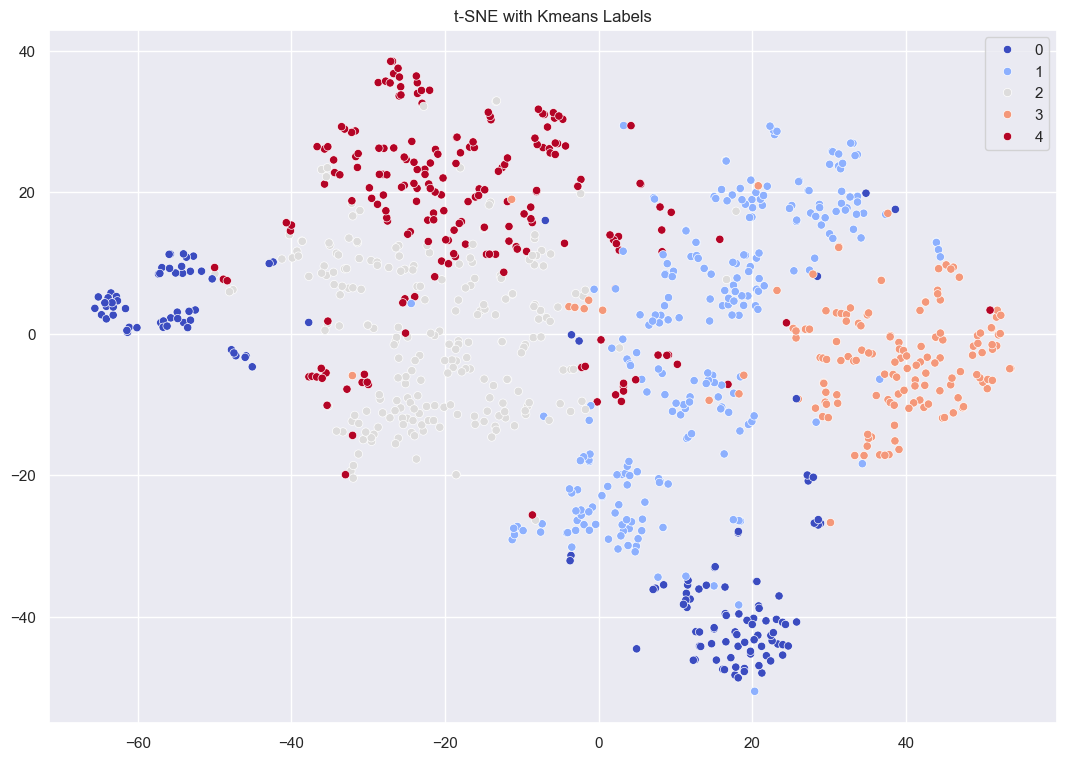

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(2, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, palette='coolwarm')
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [88]:
dfcluster["x_write"] = X_embedded[:, 0]
dfcluster["y_write"] = X_embedded[:, 1]

In [31]:
# dfcluster.head(1)

,chunkId,chunkContent,source,chunkContentVector,y,x_write,y_write
0,chunk0_0,layout forward \n target https://aka.ms/ ops \n rings \n public \n\n forward,..\data\docs\index.md,"[-0.00085263106, 0.013627768, -0.033589367, 0.0006770894, 0.007336926, 0.021093663, -0.031382557, -0.014071995, -0.0029304714, -0.0024987822, 0.031755134, -0.016508084, -0.005685401, -0.022311708, 0.004453027, 0.0032887198, 0.004736043, -0.020434486, 0.00033652954, -0.01417947, -0.017124271, -0.017840767, -0.00016860063, 0.0028946467, -0.016594063, -0.0073440913, -0.00041713542, -0.03671329, -0.009300127, -0.01735355, 0.024317898, -0.0219248, -0.02587986, -0.007358421, 0.018027056, -0.0033066322, -0.015390349, -0.007917289, -0.009400437, -0.010539667, 0.017539838, -0.006831796, 0.022111088, -0.0033066322, -0.026753986, 0.012610342, 0.00047691813, -0.014974781, -0.029691624, 0.008734095, -0.0054740347, -0.00029018117, -0.04955291, 0.005513442, 0.0118866805, -0.0044494444, -0.0040195463, -0.0011356473, 0.0020187295, -0.014537718, 0.020477476, 0.0028713606, -0.04276052, 0.0025471458, -0.0047969455, 0.0062836763, -0.016894992, 0.01751118, -0.003439184, -0.023644391, 0.04276052, 0.030981317, -0.0070574926, 0.0014043335, -0.0031687065, -0.011750546, -0.018700564, -0.027671102, 0.008884559, -0.0067995535, 0.029662963, 0.008920384, -0.001252078, 0.02848791, 0.019230772, 0.021953458, -0.006935688, 0.02811533, 0.003326336, -0.009787345, 0.021050673, 0.005140864, 0.013799726, 0.005617334, -0.020176547, 0.022626966, 0.0059254277, 0.024661817, -0.01514674, -0.01957469, ...]",3,0.525234,3.310192


## Generate word clouds per cluster


In [89]:
print("Generate words per cluster...")

Generate word clouds per cluster


In [90]:
%%capture --no-display
vectorizers = []

for ii in range(k):  # Use our optimum k
    vectorizers.append(
        CountVectorizer(
            min_df=5,
            max_df=0.9,
            stop_words="english",
            lowercase=True,
            token_pattern="[a-zA-Z\-][a-zA-Z\-]{2,}",
        )
    )

vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(
            cvec.fit_transform(
                dfcluster.loc[dfcluster["y"] == current_cluster, "chunkContent"]
            )
        )
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [91]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 1

lda_models = []

for ii in range(0, 5):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(
        n_components=NUM_TOPICS_PER_CLUSTER,
        max_iter=10,
        learning_method="online",
        verbose=False,
        random_state=42,
    )
    lda_models.append(lda)

lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=1,
                          random_state=42, verbose=False)

In [92]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))

    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [93]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []

    for idx, topic in enumerate(model.components_):
        words = [
            (vectorizer.get_feature_names_out()[i], topic[i])
            for i in topic.argsort()[: -top_n - 1 : -1]
        ]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])

    keywords.sort(key=lambda x: x[1])
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [94]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [95]:
# print(all_keywords)

Cluster 1's Keywords:


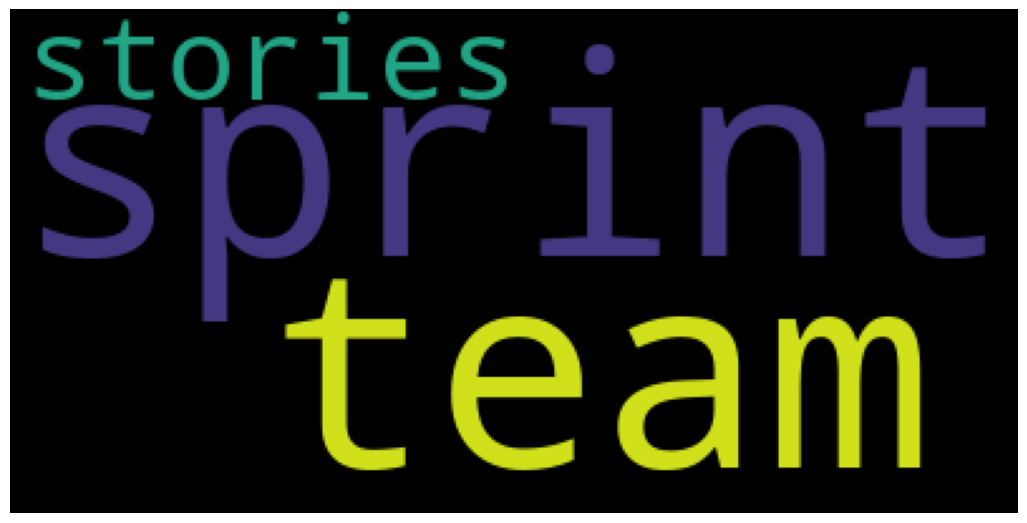

Cluster 2's Keywords:


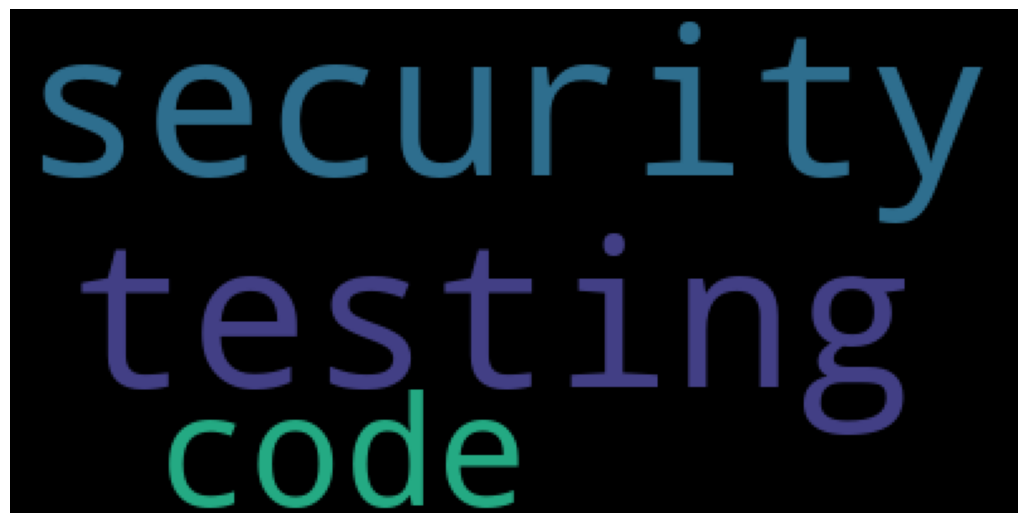

Cluster 3's Keywords:


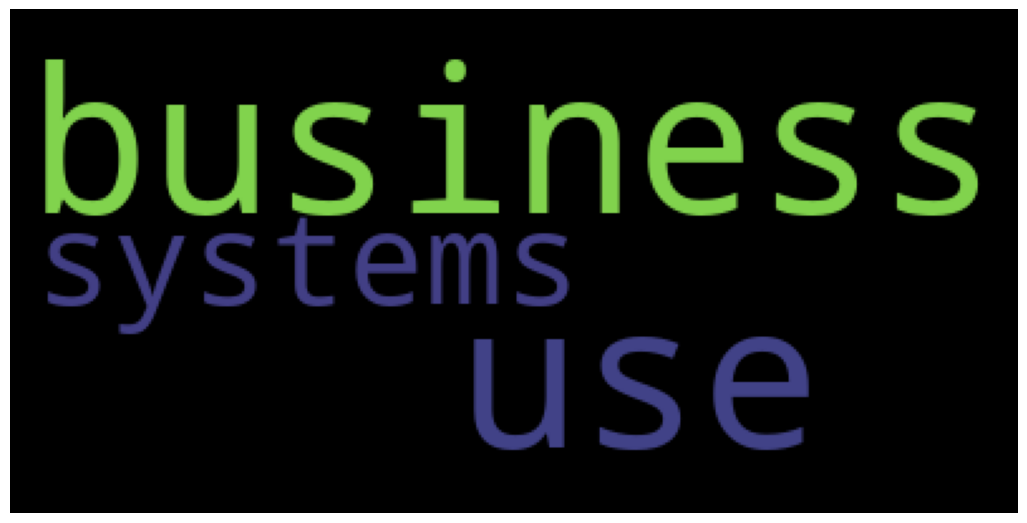

Cluster 4's Keywords:


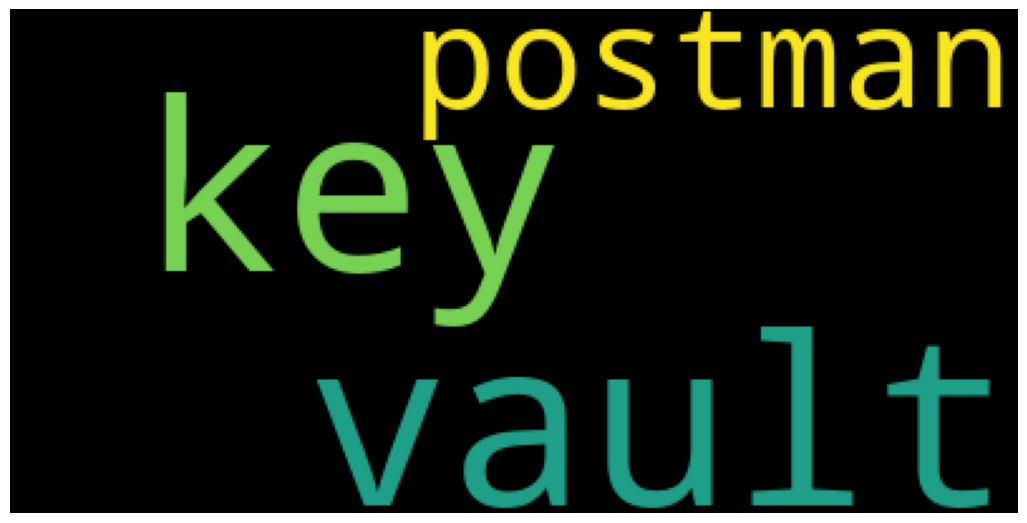

Cluster 5's Keywords:


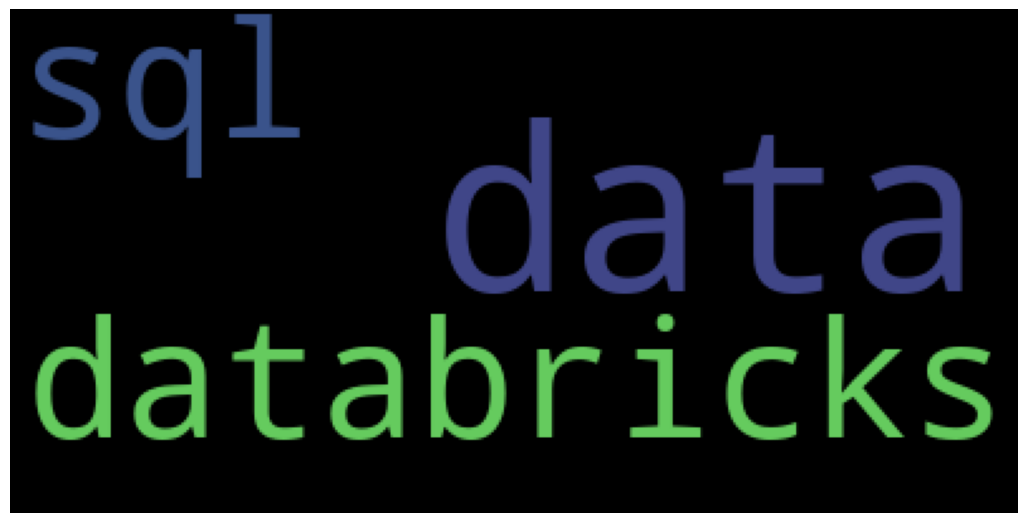

<Figure size 1300x900 with 0 Axes>

In [96]:
from wordcloud import WordCloud

i = 1
for et in all_keywords:
    print(f"Cluster {i}'s Keywords:")
    extracted_topic = " ".join(et)

    # Instantiate wordcloud object and use method to feed it our corpus
    wc = WordCloud().generate_from_text(extracted_topic)

    # Use matplotlib.pyplot to display the fitted wordcloud
    # Turn axis off to get rid of axis numbers
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    plt.savefig(f"cluster{i}.png")
    i+=1 